In [1]:
import locale
locale.setlocale(locale.LC_NUMERIC, 'C')
import sys
sys.path.append('/Users/nwilming/u')
sys.path.append('/Users/nwilming/libcmaes/python/')
import seaborn as sns
from conf_analysis.behavior import normative as nrm, fstnrm as fast
from conf_analysis.pupil import pupil, patsy_transforms as pt
from conf_analysis.behavior import empirical
from pylab import *
import pandas as pd
from conf_analysis import behavior
color_palette = behavior.color_palette
%matplotlib inline
%load_ext autoreload
%autoreload 2
%aimport -fast
sns.set_style('ticks')

/Users/nwilming/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Can an early stopping model explain the psychophysical kernels?

 1. We observe a primacy effect in choice kernels! This could be due to an early stopping model.
 2. We also observe a primacy effect and assymetry in confidence kernels. Here the question is whether an early stopping model can explain this by assuming a bias.
 
I will assume that observers compute LPR as defined by the normative model (and compare this to just using the mean value). Based on the LPR, observers make a response based on a decision threshold and a confidence threshold. In detail, I assume that a decision is made as soon as the LPR passes the decision threshold and that a confidence judgment is made after the confidence threshold is passed.
 
To compute the LPR I need a prior. This is it:

In [2]:
data = empirical.load_data()
data = empirical.data_cleanup(data)

In [3]:
def zscore_contrast(data):
    con = vstack(data.contrast_probe)
    m = mean(con)
    s = abs(con-mean(con)).std()
    idx = where(data.columns=='contrast_probe')[0][0]
    for i in range(len(data)): 
        data['contrast_probe'].values[i] = (data.iloc[i, idx]-m)/s
    data['contrast_block_mean'] = m
    data.loc[:, 'contrast'] = (data.loc[:, 'contrast']+0.5-m)/s
    return data

dz = data.copy().groupby(['snum', 'session_num', 'block_num']).apply(zscore_contrast)
dz['mc'] = array([mean(k) for k in dz.contrast_probe.values])
dz['stdc'] = array([std(k) for k in dz.contrast_probe.values])

In [4]:
from conf_analysis.behavior import early_stopping

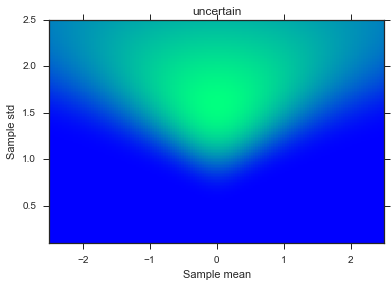

In [5]:
prior = early_stopping.get_prior(dz, N_samples=2)
M, P = meshgrid(linspace(-2.5, 2.5, 150), nrm.s2p(linspace(0.1, 2.5, 150)))
pcolor(M, nrm.p2s(P), nrm.NG(M, P, *prior), cmap=winter())
xlim([-2.5, 2.5])
ylim([0.1, 2.5])
title('uncertain')
xlabel('Sample mean')
ylabel('Sample std')

With this we can compute the LPR. It is shown below for all trials:

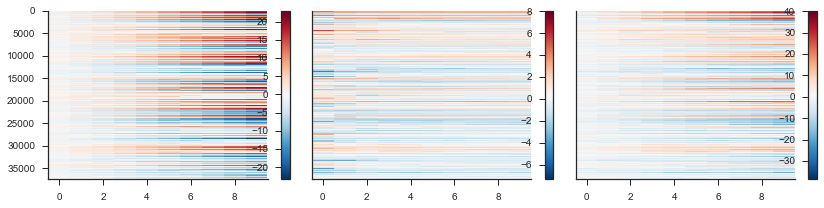

In [9]:
figure(figsize=(12, 3))
cvals = vstack(dz.contrast_probe)
cLPR = nrm.cumulative_LLPR(cvals, prior)
means = cumsum(cvals, 1)/arange(1, 11)[newaxis,:]
sums = cumsum(cvals, 1)
subplot(1,3,1)
imshow(cLPR, aspect='auto', interpolation='none', cmap='RdBu_r',)
colorbar()
subplot(1,3,2)
imshow(means, aspect='auto', interpolation='none', cmap='RdBu_r',)
yticks([])
colorbar()
subplot(1,3,3)
imshow(sums, aspect='auto', interpolation='none', cmap='RdBu_r',)
colorbar()
sns.despine()
yticks([])
tight_layout()

To get a good overview I show the distribution of LPR values for each sample and response. The top plot shows the LPR and the bottom plot shows the sum of contrast values. LPR seems to be more affected by different variance levels.

In [10]:
def center(foo):
    return array([low+(high-low)/2. for low, high in zip(foo[:-1], foo[1:])])

/Users/nwilming/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


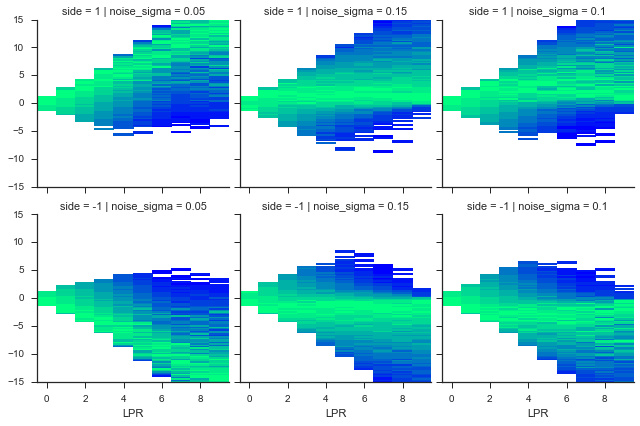

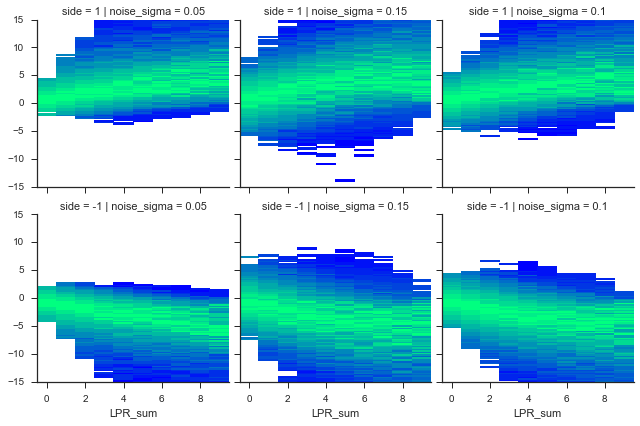

In [11]:
cLPR = nrm.cumulative_LLPR(cvals + 0*randn(*cvals.shape), prior)
m =  pd.Series([l for l in cLPR], index=dz.index)
dz.loc[:, 'LPR'] = m

m =  pd.Series([l for l in means], index=dz.index)
dz.loc[:, 'LPR_mean'] = m
m =  pd.Series([l for l in sums], index=dz.index)
dz.loc[:, 'LPR_sum'] = m

def foo(data, color=None):
    s1 = vstack(data.values)
    x = tile(arange(10), (s1.shape[0], 1))
    a,b,c=histogram2d(x.ravel(), s1.ravel(), bins=[linspace(-.5, 9.5, 11), linspace(-15, 15, 121)])
    a = vstack([prctile_rank(k, arange(0, 100, 5)) for k in a]).astype(float)
    #contour(center(b), center(c), a.T, 5)
    a[a==0] = nan
    pcolormesh(b, c, np.ma.masked_invalid(a).T)
    xlim([-.5, 9.5])

g = sns.FacetGrid(data=dz, col='noise_sigma', row='side')
g.map(foo, 'LPR')

g = sns.FacetGrid(data=dz, col='noise_sigma', row='side')
g.map(foo, 'LPR_sum')

With this in mind we can compute psychophysical decision kernels for different models (LPR, mean contrast value and sum of contrast values).

In [12]:
dcut, lpr_prop = early_stopping.determine_dcut(dz)
dcut_mean, mean_prop = early_stopping.determine_dcut(dz, field='LPR_mean')
dcut_sum, sum_prop = early_stopping.determine_dcut(dz, field='LPR_sum')
print 'LPR:', dcut, lpr_prop
print 'Mean:', dcut_mean, mean_prop
print 'Sum:', dcut_sum, sum_prop


LPR: 2.33333333333 0.736178883586
Mean: 7.66666666667 0.73234489785
Sum: 4.0 0.734275296263


In [13]:
decision_palette = {
   r'$E_N$':color_palette['Secondary2'][0], 
   r'$E_S$':color_palette['Secondary1'][0], 
   r'$E_D = E_S + E_N$':color_palette['Primary'][0]}

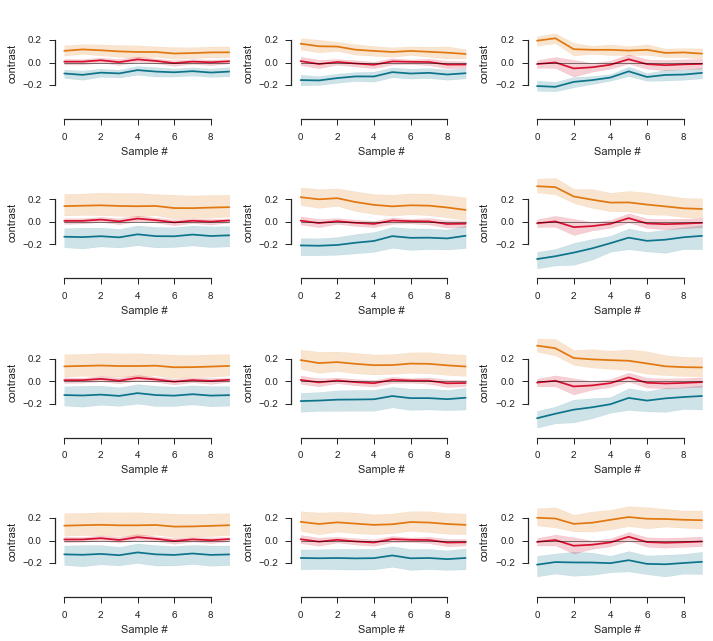

In [17]:
figure(figsize=(10, 9))   


ks = []
decision_results = []
for i, (nd, d) in enumerate(dz.groupby('noise_sigma')):

    subplot(4, 3, i+1)    
    kernels = empirical.get_decision_kernel(d, contrast_mean=0.)
    g = empirical.plot_kernel(kernels, decision_palette)
    legend('')    
    ylim(-.5, .5)
    kernels.loc[:, 'type'] = 'empirical'
    kernels.loc[:, 'noise_sigma'] = nd
    ks.append(kernels)
    kds = []
    for j, (field, dc) in enumerate([('LPR', dcut),  ('LPR_sum', dcut_sum), ('LPR_mean', dcut_mean)]):
        subplot(4, 3, (j+1)*3+i+1)
        resp, conf, ft = early_stopping.decide_trial(vstack(d[field].values), ccut=10, dcut=dc)
        d.loc[:, 'sim_response'] = resp
        d.loc[:, field + '_fp'] = ft
        kernels_sim = empirical.get_decision_kernel(d, contrast_mean=0., response_field='sim_response')
        kernels_sim.loc[:, 'type'] = field
        kernels_sim.loc[:, 'noise_sigma'] = nd
        ks.append(kernels_sim)
        g = empirical.plot_kernel(kernels_sim, decision_palette)
        legend('')    
        ylim(-.5, .5)

    decision_results.append(d.loc[:, ('snum', 'noise_sigma', 'response', 'LPR_fp', 'LPR_sum_fp', 'LPR_mean_fp')])

kernels = pd.concat(ks)
decision_results = pd.concat(decision_results)
tight_layout()

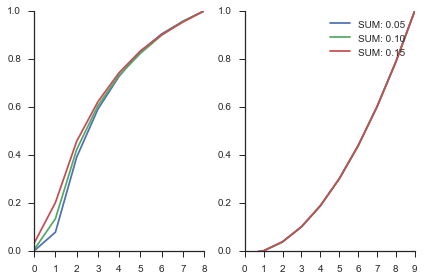

In [18]:
for i,(a, b) in enumerate(decision_results.groupby('noise_sigma')):
    subplot(1,2,1)
    lpr, lprsum = histogram(b.loc[:, ('LPR_fp', 'LPR_sum_fp')].values, bins=arange(-0.5, 9.5, 1))
    plot(cumsum(lpr)/float(sum(lpr)), label='LPR: %2.2f'%a)
    subplot(1,2,2)
    plot(cumsum(lprsum)/float(sum(lprsum)), label='SUM: %2.2f'%a)
    ylim([0, 1])
    
sns.despine()
tight_layout()
legend()

Qualitatively speaking the kernels look very similiar, except for a scaling differences. The difference traces are identical between different models. They must be due to some underlying source that is present in all models. Two investigate fit quality I compute the correlation between each model and empricial kernels across participants:

In [19]:
kernels = kernels.reset_index().set_index(['optidx', 'snum', 'time'])

In [20]:
def foo(x):
    return pd.DataFrame({'lpr':
                         corrcoef(x.query('type=="empirical"').contrast, 
                                  x.query('type=="LPR"').contrast)[0, 1],
                  'mean':
                         corrcoef(x.query('type=="empirical"').contrast, 
                                  x.query('type=="LPR_mean"').contrast)[0, 1],
                  'sum':
                         corrcoef(x.query('type=="empirical"').contrast, 
                                  x.query('type=="LPR_sum"').contrast)[0, 1],
                 }, index=[1])
    
correlations = (kernels
                    .reset_index()
                    .groupby(['snum', 'noise_sigma', 'Kernel'])
                    .apply(foo)) 

correlations =  correlations.stack()
correlations = correlations.reset_index()
correlations.columns = ['snum', 'noise_sigma', 'Kernel', 'idx', 'type', 'Correlation']
correlations = correlations.query('Kernel=="$E_N$" | Kernel=="$E_S$"') 


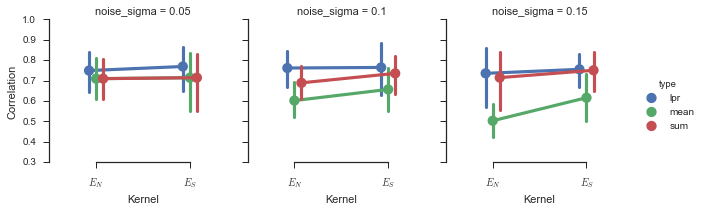

In [21]:
correlations.Kernel = correlations.Kernel.cat.remove_unused_categories()
sns.factorplot(x='Kernel', y='Correlation', data=correlations, hue='type', 
               col='noise_sigma', size=3, dodge=0.15)
sns.despine(trim=True)

## Confidence kernels

0 0.05
LPR 11.3333333333 0.579529347465
LPR_sum 5.33333333333 0.584497208922
1 0.1
LPR 5.33333333333 0.576038139248
LPR_sum 6.0 0.587050817739
2 0.15
LPR 4.0 0.554439133207
LPR_sum 7.33333333333 0.571957307788


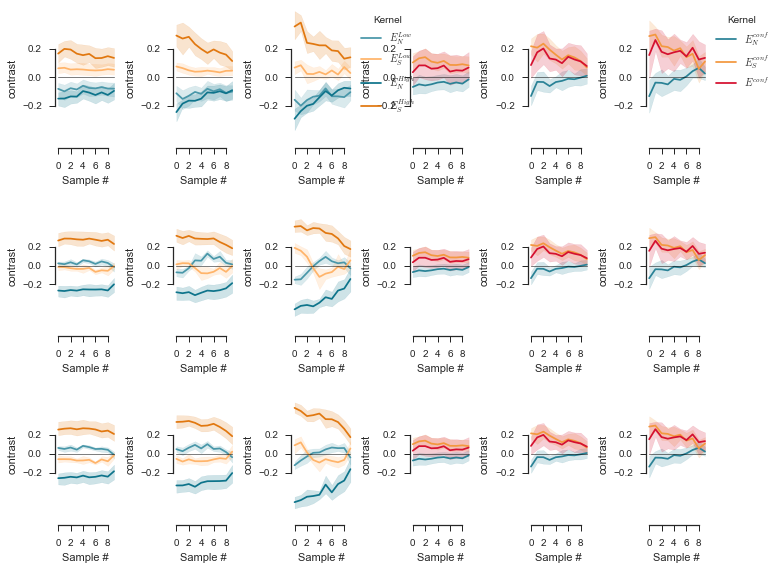

In [26]:
figure(figsize=(10, 8))    
palette = {r'$E_{N}^{High}$': color_palette['Secondary2'][0],
           r'$E_{N}^{Low}$': color_palette['Secondary2'][1], 
           r'$E_{S}^{Low}$': color_palette['Secondary1'][1], 
           r'$E_{S}^{High}$': color_palette['Secondary1'][0]}

diff_palette = {r'$E_{N}^{conf}$':color_palette['Secondary2'][2], 
           r'$E_{S}^{conf}$':color_palette['Secondary1'][2],
           r'$E^{conf}$':color_palette['Primary'][0]}
gs = matplotlib.gridspec.GridSpec(3, 6)

for i, (c, d) in enumerate(dz.groupby('noise_sigma')):
    print i, c
    subplot(gs[0, i])
    kernel = empirical.get_confidence_kernels(d)
    g = empirical.plot_kernel(kernel, palette)
    if i==2:
        g.get_legend().set_bbox_to_anchor((1., 1))
    else:
        legend('')
    ylim(-.5, .5)
    subplot(gs[0, i+3])
    kernel = empirical.get_confidence_kernel(d)
    g = empirical.plot_kernel(kernel, diff_palette)
    if i==2:
        g.get_legend().set_bbox_to_anchor((1., 1))
    else:
        legend('')
    ylim(-.5, .5)
    
    for j, (field, dc) in enumerate([('LPR', dcut), ('LPR_sum', dcut_sum)]):
        subplot(gs[j+1, i])
        ccut, cprop, idt = early_stopping.determine_ccut(d, dc, field=field)
        print field, ccut, cprop[idt]
        resp, conf, ft = early_stopping.decide_trial(vstack(d[field].values), ccut=ccut, dcut=dc)
        d.loc[:, 'sim_response'] = resp
        d.loc[:, 'sim_confidence'] = conf
        kernels_sim = empirical.get_confidence_kernels(d, response_field='sim_response', confidence_field='sim_confidence')
        kernels_sim.loc[:, 'type'] = field
        kernels_sim.loc[:, 'noise_sigma'] = nd
        ks.append(kernels_sim)
        g = empirical.plot_kernel(kernels_sim, palette)
        g.get_legend().set_bbox_to_anchor((.65, .45))
        legend('')    
        ylim(-.75, .75)
        
        subplot(gs[j+1, i+3])
        kernel_diff = empirical.get_confidence_kernel(d)
        g = empirical.plot_kernel(kernel_diff, diff_palette)
        legend('')    
        ylim(-.75, .75)
tight_layout()

In [27]:
early_stopping.decide_trial_prob(vstack(dz.LPR), dcut=2.5, alpha=0.5, offset=0)

(array([ 1.,  1.,  1., ..., -1.,  1., -1.]),
 array([2, 2, 1, ..., 2, 1, 1]),
 array([ 4.,  6.,  2., ...,  6.,  4.,  4.]),
 array([ 0.62245933,  0.81757448,  0.37754067, ...,  0.81757448,
         0.62245933,  0.62245933]),
 array([ 0.9,  0.9,  0.9, ...,  0.1,  0.9,  0.1]))

In [28]:
dz = dz.loc[~isnan(dz.confidence), :]
d = dz.query('noise_sigma==0.15')


In [29]:
d.confidence.head()

8     1.0
17    1.0
19    2.0
25    2.0
26    2.0
Name: confidence, dtype: float64

In [39]:
from itertools import product
%time cc, off, dc, scores, idt, Al, Off, Dc = early_stopping.determine_first_passage_thresholds(d)

CPU times: user 2min 50s, sys: 1.22 s, total: 2min 52s
Wall time: 2min 55s


(11, 13, 12)
4.54545454545 3.5 -0.166666666667


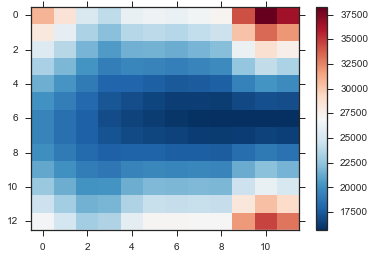

In [40]:
print scores.shape
#print unique(scores)
#pcolor(Dc[0, :, :],  Off[0, :, :], array(scores).reshape(Al.shape)[0, :, :], cmap='RdBu_r')
imshow(scores[1, :, :], cmap='RdBu_r', interpolation='None', aspect='auto')
colorbar()
print dc, off, cc 

In [50]:
d = dz.query('noise_sigma==0.15')
%time alpha, off, dc, scores, idt, Al, Off, Dc = early_stopping.determine_first_passage_thresholds(d)
print dc, alpha, off

CPU times: user 2min 37s, sys: 1.55 s, total: 2min 39s
Wall time: 2min 44s
4.54545454545 -0.166666666667 3.5


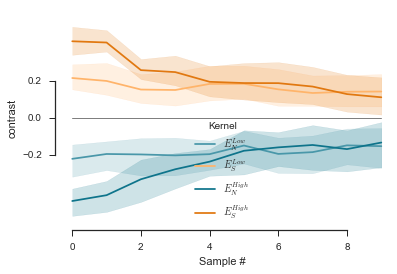

In [51]:
resp, conf,  ft, _, _ = early_stopping.decide_trial_prob(vstack(d[field].values), alpha=alpha, offset=off, dcut=dc)

d.loc[:, 'sim_response'] = resp
d.loc[:, 'sim_confidence'] = conf
kernels_sim = empirical.get_confidence_kernels(d, response_field='sim_response', confidence_field='sim_confidence')
kernels_sim.loc[:, 'type'] = field
kernels_sim.loc[:, 'noise_sigma'] = nd
ks.append(kernels_sim)
g = empirical.plot_kernel(kernels_sim, palette)

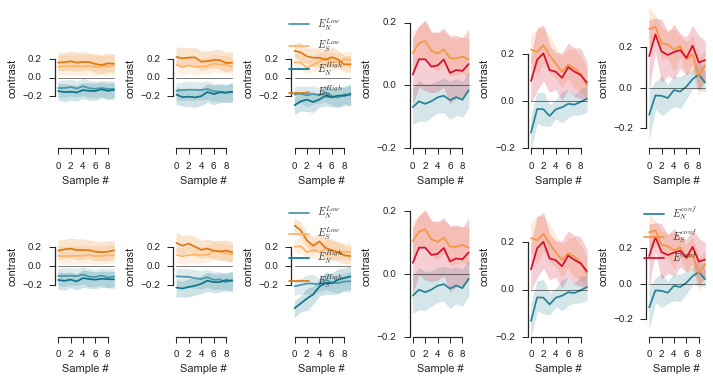

In [54]:
from scipy.stats import bernoulli
figure(figsize=(10, 8))    
palette = {r'$E_{N}^{High}$': color_palette['Secondary2'][0],
           r'$E_{N}^{Low}$': color_palette['Secondary2'][1], 
           r'$E_{S}^{Low}$': color_palette['Secondary1'][1], 
           r'$E_{S}^{High}$': color_palette['Secondary1'][0]}

diff_palette = {r'$E_{N}^{conf}$':color_palette['Secondary2'][2], 
           r'$E_{S}^{conf}$':color_palette['Secondary1'][2],
           r'$E^{conf}$':color_palette['Primary'][0]}
gs = matplotlib.gridspec.GridSpec(3, 6)

for i, (c, d) in enumerate(dz.groupby('noise_sigma')):    
    for j, (field, dc) in enumerate([('LPR', dcut), ('LPR_sum', dcut_sum)]):
        subplot(gs[j+1, i])
        alpha, off, dc, scores, idt, Al, Off, Dc = early_stopping.determine_first_passage_thresholds(d)        
        resp, conf,  ft, _, _ = early_stopping.decide_trial_prob(vstack(d[field].values), 
                                                                 alpha=alpha, offset=off, dcut=dc)

        d.loc[:, 'sim_response'] = resp
        d.loc[:, 'sim_confidence'] = conf
        kernels_sim = empirical.get_confidence_kernels(d, response_field='sim_response', 
                                                       confidence_field='sim_confidence')
        kernels_sim.loc[:, 'type'] = field
        kernels_sim.loc[:, 'noise_sigma'] = nd
        ks.append(kernels_sim)
        g = empirical.plot_kernel(kernels_sim, palette)
        g.get_legend().set_bbox_to_anchor((.65, .45))
        legend('')    
        ylim(-.75, .75)
        if i==2:
            legend()
        subplot(gs[j+1, i+3])
        kernel_diff = empirical.get_confidence_kernel(d)
        g = empirical.plot_kernel(kernel_diff, diff_palette)
        legend('')    
        #ylim(-.2, .2)
legend()
tight_layout()

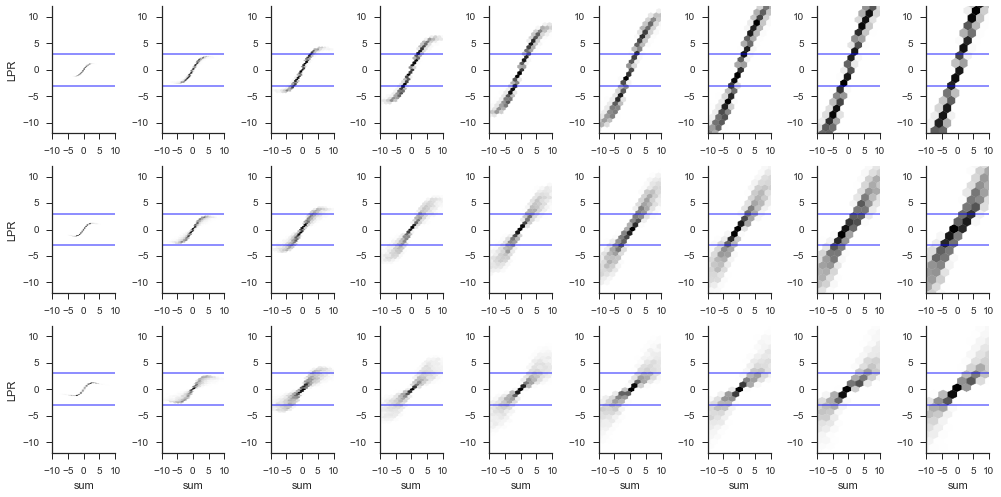

In [55]:
figure(figsize=(14, 7))
gs = matplotlib.gridspec.GridSpec(3, 9)
for i, (ns, nsd) in enumerate(dz.groupby('noise_sigma')):
    LPR = vstack(nsd.LPR)
    sums = vstack(nsd.LPR_sum)
    cc = vstack(nsd.contrast_probe)
    for k in range(9):
        subplot(gs[i, k])
        
        hexbin(sums[:, k].ravel(), LPR[:, k].ravel(), gridsize=25, cmap='gray_r')
        if i==2:
            xlabel('sum')
        if k==0:
            ylabel('LPR')
        ylim([-12, 12])
        xlim(-10, 10)
        axhline(3, alpha=0.5)
        axhline(-3, alpha=0.5)
sns.despine()
tight_layout()